In [14]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

print("numpy:", np.__version__)
print("pandas:", pd.__version__)


numpy: 2.0.2
pandas: 2.2.2


In [15]:
CANDIDATE_PATHS = [
    "/content/Creditcard_data.csv",  # common Colab path after upload/download
    "/mnt/data/22569646-faef-49e6-ac28-5b098079615b.csv",  # if running in this environment
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    # download into /content
    !wget -q -O /content/Creditcard_data.csv "{GITHUB_RAW}"
    DATA_PATH = "/content/Creditcard_data.csv"

df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())

Loaded: /content/Creditcard_data.csv
Shape: (772, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
target_col = "Class" if "Class" in df.columns else df.columns[-1]

print("\nTarget column:", target_col)
print("\nClass distribution (original):")
print(df[target_col].value_counts())
print("\nClass distribution % (original):")
print((df[target_col].value_counts(normalize=True) * 100).round(3))


Target column: Class

Class distribution (original):
Class
0    763
1      9
Name: count, dtype: int64

Class distribution % (original):
Class
0    98.834
1     1.166
Name: proportion, dtype: float64


In [17]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Handle any missing values (just in case)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))



In [18]:
smote_balancer = SMOTE(random_state=42)
X_bal, y_bal = smote_balancer.fit_resample(X, y)
df_balanced = pd.concat([pd.DataFrame(X_bal, columns=X.columns),
                         pd.Series(y_bal, name=target_col)], axis=1)

balanced_out_path = "/content/Creditcard_data_balanced_smote.csv"
df_balanced.to_csv(balanced_out_path, index=False)

print("\nBalanced dataset (SMOTE) class distribution:")
print(pd.Series(y_bal).value_counts())
print("Saved balanced dataset to:", balanced_out_path)


Balanced dataset (SMOTE) class distribution:
Class
0    763
1    763
Name: count, dtype: int64
Saved balanced dataset to: /content/Creditcard_data_balanced_smote.csv


In [19]:
# Create five samples (5-fold Stratified CV)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [20]:

# Define five sampling techniques (Sampling1..Sampling5)
samplers = {
    "Sampling1_RandomUnder": RandomUnderSampler(random_state=42),
    "Sampling2_RandomOver":  RandomOverSampler(random_state=42),
    "Sampling3_SMOTE":       SMOTE(random_state=42),
    "Sampling4_ADASYN":      ADASYN(random_state=42),
    "Sampling5_SMOTEENN":    SMOTEENN(random_state=42),
    # You can swap Sampling5 to SMOTETomek if preferred:
    # "Sampling5_SMOTETomek":  SMOTETomek(random_state=42),
}


In [21]:
# Define five ML models (M1..M5)
models = {
    "M1_LogReg": LogisticRegression(
        solver="saga", max_iter=3000, n_jobs=-1, random_state=42
    ),
    "M2_RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "M3_GradBoost": GradientBoostingClassifier(random_state=42),
    "M4_SVC": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "M5_KNN": KNeighborsClassifier(n_neighbors=5),
}

# Models that generally benefit from scaling
needs_scaling = {"M1_LogReg", "M4_SVC", "M5_KNN"}


In [22]:
results = pd.DataFrame(index=models.keys(), columns=samplers.keys(), dtype=float)

for m_name, model in models.items():
    for s_name, sampler in samplers.items():

        steps = [("sampler", sampler)]

        # Only scale for scaling-sensitive models
        if m_name in needs_scaling:
            steps.append(("scaler", StandardScaler()))

        steps.append(("model", model))

        pipe = ImbPipeline(steps=steps)

        scores = cross_val_score(
            pipe, X, y,
            scoring="accuracy",
            cv=cv,
            n_jobs=-1
        )

        results.loc[m_name, s_name] = scores.mean() * 100  # percent

print("\n=== Accuracy Table (%), averaged over 5 folds ===")
display(results.round(2))



=== Accuracy Table (%), averaged over 5 folds ===


,Sampling1_RandomUnder,Sampling2_RandomOver,Sampling3_SMOTE,Sampling4_ADASYN,Sampling5_SMOTEENN
M1_LogReg,56.87,89.50,90.28,90.15,88.34
M2_RandomForest,75.27,98.83,98.71,98.71,96.76
M3_GradBoost,71.23,98.70,97.93,97.80,83.43
M4_SVC,52.23,96.24,96.37,96.24,95.21
M5_KNN,60.26,96.12,92.75,92.75,88.60


In [23]:
best_sampler_per_model = results.idxmax(axis=1)
best_acc_per_model = results.max(axis=1)

summary_1 = pd.DataFrame({
    "Best_Sampling_Technique": best_sampler_per_model,
    "Best_Accuracy_%": best_acc_per_model.round(2)
}, index=results.index)

print("\n=== Best Sampling Technique for Each Model ===")
display(summary_1)



=== Best Sampling Technique for Each Model ===


,Best_Sampling_Technique,Best_Accuracy_%
M1_LogReg,Sampling3_SMOTE,90.28
M2_RandomForest,Sampling2_RandomOver,98.83
M3_GradBoost,Sampling2_RandomOver,98.70
M4_SVC,Sampling3_SMOTE,96.37
M5_KNN,Sampling2_RandomOver,96.12


In [24]:
best_model_per_sampler = results.idxmax(axis=0)
best_acc_per_sampler = results.max(axis=0)

summary_2 = pd.DataFrame({
    "Best_Model": best_model_per_sampler,
    "Best_Accuracy_%": best_acc_per_sampler.round(2)
}, index=results.columns)

print("\n=== Best Model for Each Sampling Technique ===")
display(summary_2)



=== Best Model for Each Sampling Technique ===


,Best_Model,Best_Accuracy_%
Sampling1_RandomUnder,M2_RandomForest,75.27
Sampling2_RandomOver,M2_RandomForest,98.83
Sampling3_SMOTE,M2_RandomForest,98.71
Sampling4_ADASYN,M2_RandomForest,98.71
Sampling5_SMOTEENN,M2_RandomForest,96.76


In [25]:
out_results = "/content/sampling_model_accuracy_table.csv"
out_best1 = "/content/best_sampler_per_model.csv"
out_best2 = "/content/best_model_per_sampler.csv"

results.round(4).to_csv(out_results)
summary_1.to_csv(out_best1)
summary_2.to_csv(out_best2)

In [26]:
best_overall_model = results.stack().idxmax()[0]
best_overall_sampler = results.stack().idxmax()[1]
best_overall_acc = results.stack().max()

print("\n=== Best Overall Combination ===")
print("Model:", best_overall_model)
print("Sampler:", best_overall_sampler)
print("CV Accuracy (%):", round(best_overall_acc, 2))

# Build final pipeline for report on a holdout split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

final_steps = [("sampler", samplers[best_overall_sampler])]
if best_overall_model in needs_scaling:
    final_steps.append(("scaler", StandardScaler()))
final_steps.append(("model", models[best_overall_model]))

final_pipe = ImbPipeline(steps=final_steps)
final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
print("\nHoldout Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



=== Best Overall Combination ===
Model: M2_RandomForest
Sampler: Sampling2_RandomOver
CV Accuracy (%): 98.83

Holdout Accuracy: 99.35 %

Confusion Matrix:
 [[153   0]
 [  1   1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       153
           1       1.00      0.50      0.67         2

    accuracy                           0.99       155
   macro avg       1.00      0.75      0.83       155
weighted avg       0.99      0.99      0.99       155



=== Accuracy Table (Markdown) ===
|                 |   Sampling1_RandomUnder |   Sampling2_RandomOver |   Sampling3_SMOTE |   Sampling4_ADASYN |   Sampling5_SMOTEENN |
|:----------------|------------------------:|-----------------------:|------------------:|-------------------:|---------------------:|
| M1_LogReg       |                   56.87 |                  89.5  |             90.28 |              90.15 |                88.34 |
| M2_RandomForest |                   75.27 |                  98.83 |             98.71 |              98.71 |                96.76 |
| M3_GradBoost    |                   71.23 |                  98.7  |             97.93 |              97.8  |                83.43 |
| M4_SVC          |                   52.23 |                  96.24 |             96.37 |              96.24 |                95.21 |
| M5_KNN          |                   60.26 |                  96.12 |             92.75 |              92.75 |                88.6  |

=== Best Sampler per

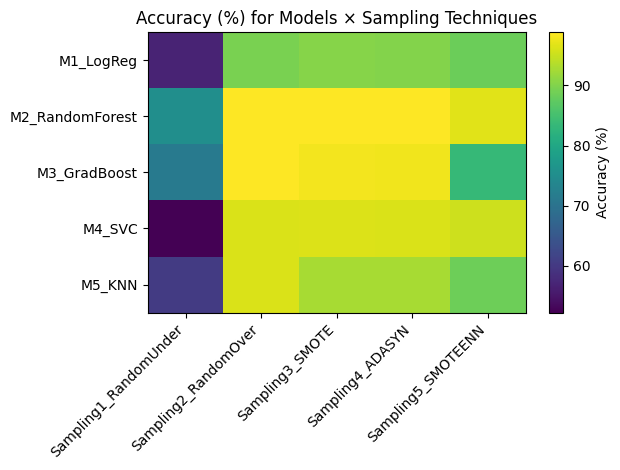

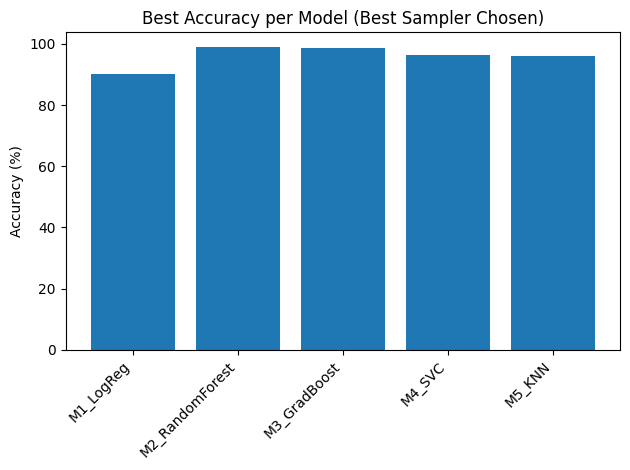

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load outputs generated by the notebook
acc = pd.read_csv("/content/sampling_model_accuracy_table.csv", index_col=0)
best1 = pd.read_csv("/content/best_sampler_per_model.csv", index_col=0)

print("=== Accuracy Table (Markdown) ===")
print(acc.round(2).to_markdown())

print("\n=== Best Sampler per Model (Markdown) ===")
print(best1.to_markdown())

# --------- Graph 1: Heatmap-like matrix (matplotlib only) ----------
plt.figure()
plt.imshow(acc.values, aspect='auto')
plt.xticks(range(len(acc.columns)), acc.columns, rotation=45, ha="right")
plt.yticks(range(len(acc.index)), acc.index)
plt.colorbar(label="Accuracy (%)")
plt.title("Accuracy (%) for Models × Sampling Techniques")
plt.tight_layout()
plt.show()

# --------- Graph 2: Best accuracy per model ----------
plt.figure()
plt.bar(best1.index, best1["Best_Accuracy_%"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.title("Best Accuracy per Model (Best Sampler Chosen)")
plt.tight_layout()
plt.show()
